# Visualization of Transformer Prediction on a map

In [18]:
import torch
import torch.nn as nn
from tptrans import TPTrans
from dataloader import load_parquet, preprocess_data, SlidingWindowDataset
from plotting import plot_testresult_sample
from torch.utils.data import DataLoader

In [19]:
#in your case it will be
#dataset = "dataset"
dataset = "dataset"

/zhome/63/7/219953/DeepLearning-1/dataloader.py:167: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.set_index("Timestamp")
/zhome/63/7/219953/DeepLearning-1/dataloader.py:167: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.set_index("Timestamp")


29
Test Loss: 0.000385


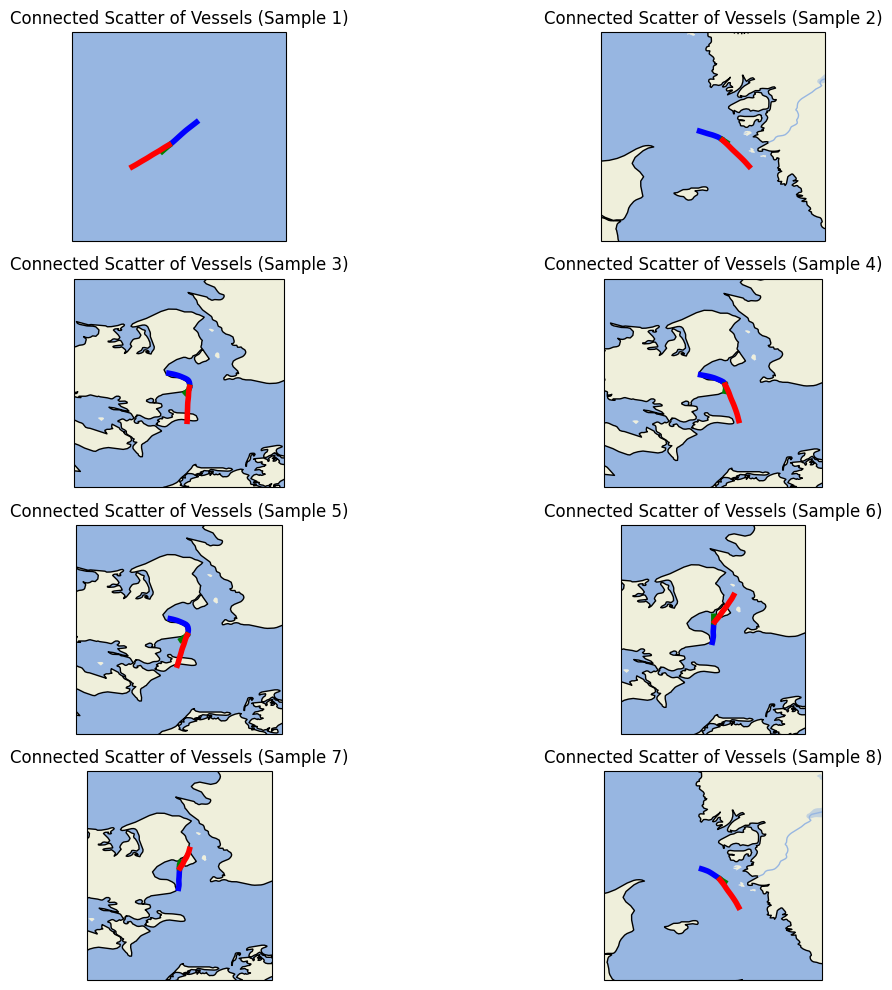

In [20]:
import torch
import torch.nn as nn
from tptrans import *
from dataloader import load_parquet, preprocess_data, SlidingWindowDataset
from plotting import plot_testresult_sample
from torch.utils.data import DataLoader
from utils import deltas_to_coords

df = load_parquet("dataset", k=10)
df = preprocess_data(df)

dataset = SlidingWindowDataset(
    df,
    max_diff_per_sequence_minutes=15,
    window_size_minutes=120,
    pred_size_minutes=30,
    stride=15,
)
print(len(dataset))

test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load("checkpoints/tprans_2500_300_20_420_120_15_64_0.0005.pth", map_location=torch.device(device), weights_only=False)
model.eval()

criterion = nn.MSELoss()
test_loss = 0.0
data = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        data.append((x,y,pred))
        pred_coords = deltas_to_coords(x, pred)
        y_coords = deltas_to_coords(x, y)
                # Example: trim pred to match y along time dim
        min_len = min(pred_coords.size(1), y_coords.size(1))
        loss = criterion(pred_coords[:, :min_len], y_coords[:, :min_len])
        test_loss += loss.item() * x.size(0)
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.6f}", flush=True)

plot_testresult_sample(data)